# Hackathon 7

Images sourced from [Isaac Dykeman's blog post on CVAE](http://ijdykeman.github.io/ml/2016/12/21/cvae.html).

Topics:
- Stochastic Computation Graphs
- Variational Autoencoder
    - Reparameterization trick
- Visualization with t-sne

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
# We'll start with our library imports...
from __future__ import print_function

import os  # to work with file paths

import tensorflow as tf         # to specify and run computation graphs
import numpy as np              # for numerical operations taking place outside of the TF graph
import matplotlib.pyplot as plt # to draw plots

mnist_dir = '/work/cse496dl/shared/hackathon/03/mnist/'
cifar_dir = '/work/cse496dl/shared/hackathon/05/'

In [2]:
# extract our dataset, MNIST
train_data = np.load(mnist_dir + 'mnist_train_images.npy')
train_data = np.reshape(train_data, [-1, 28, 28, 1])
test_data = np.load(mnist_dir + 'mnist_test_images.npy')
test_data = np.reshape(test_data, [-1, 28, 28, 1])

#### Stochastic Computation Graphs

Up to this point, we've been working entirely with deterministic transformations of data between high dimensional vector spaces. That means we assign one code to one image. We can also transform the same image vector into a 10 dimensional distribution over classes in a classifier as in classification. As hinted at by all of the statistical terms we've been using (cross-entropy, distribution over classes, etc.), the theory underlying machine learning and deep learning is based on statistics.

For example, we think of our dataset as an [iid](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables) sample of a distribution of interest (e.g., natural images, spectrograms of human voices, or EEGs taken while looking at cute puppies). Then, in classification, we transform each sample of that data distribution using our parametric network into a sample of an associated distribution over classes. Thus, we can think of our networks as functions that [transform](http://math.bme.hu/~nandori/Virtual_lab/stat/dist/Transformations.pdf) one random variable into another or parameterize conditional distributions like a [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network#Inference_and_learning).

Once we take this perspective of deep learning as learning parametric functions that transform random variables, we can think about using random variables in the middle of the graph for many reasons. We'll look at replacing the static codes of the autoencoders we studied last week with a random variable, creating the [variational autoencoder](https://arxiv.org/abs/1606.05908) (VAE), which allows us to generate data by sampling codes and transforming them into data.


#### Variational Autoencoder

Generally autoencoders associate individual latent codes with each datum. This gives us a powerful ability to transform small codes into full-sized data. Instead of individual codes, the VAE uses distributions over codes (typically Gaussian). Let's specify a stochastic encoder that, rather than a single code, outputs the parameters of the posterior distribution, a Gaussian (Normal) distribution:

In [3]:
# The input data is called X
# The latent variable is called Z
# The reconstructed data is called X-hat
# All are treated as random variables for Variational Autoencoders

def conv_block(inputs, filters, downscale=1):
    """
    Args:
        - inputs: 4D tensor of shape NHWC
        - filters: int
    """
    with tf.name_scope('conv_block') as scope:
        conv = tf.layers.conv2d(inputs, filters, 3, 1, padding='same')
        conv = tf.nn.relu(conv)
        down_conv = tf.layers.conv2d(conv, filters, 3, strides=downscale, padding='same')
        down_conv = tf.nn.relu(down_conv)
        return down_conv

def gaussian_encoder(inputs, latent_size):
    """inputs should be a tensor of images whose height and width are multiples of 4"""
    # Note using downscale=2 we do that instead of using maxpooling with stride of 2
    x = conv_block(inputs, 8, downscale=2)
    x = conv_block(x, 16, downscale=2)
    # Note the output here is split into two different dense layers below
    
    # Note for variational autoencoder we need the mean and the scale
    mean = tf.layers.dense(x, latent_size) # Referred to as mu in lecture
    log_scale = tf.layers.dense(x, latent_size) # Referred to as log-sigma in lecture
    # It is intentional that we can (of course not use activation for the mean and log_scale)
    
    return mean, log_scale

# For simplicity we treat each dimension of VAE as being independent from each other
# She thus only uses the diagonal entries in mu and log-sigma

This allows us to encode input images to certain regions of latent space. <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7ICq0ljD0bX-_pusVuPeof-7rMunTpgBoSmL25cgo12AFGF8H" width="70%">

##### The Reparameterization Trick

The real brilliance behind the VAE is the idea to reparameterize the latent variable. Rather than using the outputs of the previous layer directly as the parameters of a Gaussian, we'll instead compute a reparameterized formula that is equivalent, but has lower variance gradients:

In [4]:
def gaussian_sample(mean, log_scale):
    # Noise is zero centered and std. dev. is 1 (note these are defaults for tf.random_normal)
    gaussian_noise = tf.random_normal(shape=tf.shape(mean))
    
    # Note this means we do not need to backpropogate through random sampling due to below setup
    # Note tf.exp(log_scale) just gives scale back
    return mean + (tf.exp(log_scale) * gaussian_noise)

Then, we'll specify a deterministic decoder that transforms from the latent variable back to the data variable, just as in any other autoencoder:

In [5]:
from operator import mul
from functools import reduce

def upscale_block(x, scale=2, name='upscale_block'):
    """[Sub-Pixel Convolution](https://arxiv.org/abs/1609.05158) """
    n, w, h, c = x.get_shape().as_list()
    x = tf.layers.conv2d(x, c * scale ** 2, (3, 3), activation=tf.nn.relu, padding='same', name=name)
    output = tf.depth_to_space(x, scale)
    return output

def decoder(inputs, output_shape):
    """output_shape should be a length 3 iterable of ints"""
    h, w, c = output_shape
    initial_shape = [h // 4, w // 4, c]
    initial_size = reduce(mul, initial_shape)
    x = tf.layers.dense(inputs, initial_size // 32, name='decoder_dense')
    x = tf.reshape(x, [-1] + initial_shape)
    x = upscale_block(x, name='upscale1')
    return upscale_block(x, name='upscale2')

This allows us to specify the decoder which will produce good digits from codes sampled from the unit normal distribution. <img src="http://ijdykeman.github.io/assets/cvae_figures/vae_decoder_diagram.svg" width="70%">

##### VAE loss

The VAE loss is the sum of two components: latent loss and reconstruction loss.

The latent loss penalizes each [posterior distribution](https://en.wikipedia.org/wiki/Posterior_probability) for its KL-divergence from the [prior distribution](https://en.wikipedia.org/wiki/Prior_probability). This pushes the model to assign codes so that we can sample from the prior distribution and transform it into the data distribution, and regularizes the model (note that we use no other regularization in the model below). We've chosen the standard normal (Gaussian) distribution, `N(0,1)` to be the prior, so we use `std_gaussian_KL_divergence` to calculate the KL divergence.

<img src="http://ijdykeman.github.io/assets/cvae_figures/kl_divergence_diagram.svg" width="80%">

The reconstruction loss is a probabilistic approach to calculating the distance between two images. Instead of interpreting the output of the decoder as a static image, we interpret it as the mean parameter of a distribution and then calculate the log-likelihood of the data under that distribution. I've provided `bernoulli_logp` and `discretized_logistic_logp` as two basic options, but other distributions can be used as well. [Bernoulli](https://en.wikipedia.org/wiki/Bernoulli_distribution) seems like a natural choice for greyscale images with its single parameter equal to the decoder output, but [discretized logistic](https://en.wikipedia.org/wiki/Logistic_distribution) has been used by some powerful models lately. It uses the decoder output as the distribution mean and learns the scale as a separate parameter over the entire dataset. Note that these distributions are usually only used in the calculation of the reconstruction loss, with the decoder output taken as the sampled image.

Finally, the provided `vae_loss` function provides a neat interface to all this calculation and returns a tuple of the losses, which can be summed to get the total VAE loss.

In [6]:
# define an epsilon
EPS = 1e-10

def std_gaussian_KL_divergence(mu, log_sigma):
    """Analytic KL distance between N(mu, e^log_sigma) and N(0, 1)"""
    sigma = tf.exp(log_sigma)
    return -0.5 * tf.reduce_sum(
        1 + tf.log(tf.square(sigma)) - tf.square(mu) - tf.square(sigma), 1)

def flatten(inputs):
    """
    Flattens a tensor along all non-batch dimensions.
    This is correctly a NOP if the input is already flat.
    """
    if len(shape(inputs)) == 2:
        return inputs
    else:
        size = inputs.get_shape().as_list()[1:]
        return tf.reshape(inputs, [-1, size])

def bernoulli_logp(alpha, sample):
    """Calculates log prob of sample under bernoulli distribution.
    
    Note: args must be in range [0,1]
    """
    # Given data and distribution what is probability I sampled this from this distribution
    # We treat output of the decoder as the parameters of a bernoulli distribution
    # Each pixel is treated as if it was a coin flip (black pixel or white pixel)
    alpha = flatten(alpha)
    sample = flatten(sample)
    return tf.reduce_sum(sample * tf.log(EPS + alpha) +
                         ((1 - sample) * tf.log(EPS + 1 - alpha)), 1)

def discretized_logistic_logp(mean, logscale, sample, binsize=1 / 256.0):
    """Calculates log prob of sample under discretized logistic distribution."""
    scale = tf.exp(logscale)
    sample = (tf.floor(sample / binsize) * binsize - mean) / scale
    logp = tf.log(
        tf.sigmoid(sample + binsize / scale) - tf.sigmoid(sample) + EPS)

    if logp.shape.ndims == 4:
        logp = tf.reduce_sum(logp, [1, 2, 3])
    elif logp.shape.ndims == 2:
        logp = tf.reduce_sum(logp, 1)
    return logp

def vae_loss(inputs, outputs, latent_mean, latent_log_scale, output_dist, output_log_scale=None):
    """Calculate the VAE loss (aka [ELBO](https://arxiv.org/abs/1312.6114))
    
    Args:
        - inputs: VAE input
        - outputs: VAE output
        - latent_mean: parameter of latent distribution
        - latent_log_scale: log of std. dev. of the latent distribution
        - output_dist: distribution parameterized by VAE output, must be in ['logistic', 'bernoulli']
        - output_log_scale: log scale parameter of the output dist if it's logistic, can be learnable
        
    Note: output_log_scale must be specified if output_dist is logistic
    """
    # Calculate reconstruction loss
    # Equal to minus the log likelihood of the input data under the VAE's output distribution
    if output_dist == 'bernoulli':
        outputs = tf.sigmoid(outputs)
        reconstruction_loss = -bernoulli_logp(outputs, inputs)
    elif output_dist == 'logistic':
        outputs = tf.clip_by_value(outputs, 1 / 512., 1 - 1 / 512.)
        reconstruction_loss = -discretized_logistic_logp(outputs, output_log_scale, inputs)
    else:
        print('Must specify an argument for output_dist in [bernoulli, logistic]')
    reconstruction_loss = tf.reduce_mean(reconstruction_loss)
        
    # Calculate latent loss
    latent_loss = std_gaussian_KL_divergence(latent_mean, latent_log_scale)
    latent_loss = tf.reduce_mean(latent_loss)
    
    return reconstruction_loss, latent_loss

Now, let's specify the full VAE using the logistic output distribution: <img src="http://ijdykeman.github.io/assets/cvae_figures/vae_diagram.svg" width="80%">

In [7]:
latent_size = 10
img_shape = [28, 28, 1]

tf.reset_default_graph()
inputs = tf.placeholder(tf.float32, shape=[None] + img_shape)

# VAE
with tf.variable_scope("model") as scope:
    means, log_scales = gaussian_encoder(inputs, latent_size)
    codes = gaussian_sample(means, log_scales)
    outputs = decoder(codes, img_shape)
with tf.variable_scope("model", reuse=True) as scope:
    gen_sample = decoder(codes, img_shape)

# calculate loss with learnable parameter for output log_scale ???
output_log_scale = tf.get_variable("output_log_scale", initializer=tf.constant(0.0, shape=img_shape))
reconstruction_loss, latent_loss = vae_loss(inputs, outputs, means, log_scales, 'logistic', output_log_scale)

W1019 12:24:43.978266 47063482753152 deprecation.py:323] From <ipython-input-3-306015a4115c>:13: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W1019 12:24:43.996483 47063482753152 deprecation.py:506] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1019 12:24:44.832530 47063482753152 deprecation.py:323] From <ipython-input-3-306015a4115c>:27: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.


And train the model:

In [8]:
# setup optimizer
total_loss = reconstruction_loss + latent_loss
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(total_loss)

# train for an epoch and visualize
batch_size = 128
session = tf.Session()
session.run(tf.global_variables_initializer())
for epoch in range(5):
    print("EPOCH", epoch)
    for i in range(train_data.shape[0] // batch_size):
        batch_xs = train_data[i*batch_size:(i+1)*batch_size, :]
        session.run(train_op, {inputs: batch_xs})
print("Done!")

W1019 12:24:46.692682 47063482753152 deprecation.py:323] From /util/opt/anaconda/deployed-conda-envs/packages/tensorflow/envs/tensorflow-1.14.0-py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


EPOCH 0
EPOCH 1
EPOCH 2
EPOCH 3
EPOCH 4
Done!


Then we'll run a test to check out how it performs. First we encode an input image:

Input image


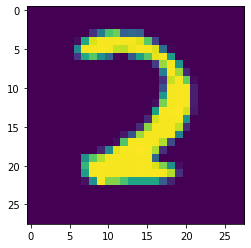

In [9]:
# run a test
idx = np.random.randint(test_data.shape[0])
inputs_data = np.repeat(np.expand_dims(test_data[idx], axis=0), 3, axis=0)
inputs_out, output_log_scale, outputs_out = session.run([inputs, output_log_scale, outputs], {inputs: inputs_data})
print("Input image")
plt.imshow(np.squeeze(inputs_out[0]))

Then we'll sample from the posterior distribution a few times and visualize the results.

Reconstruction


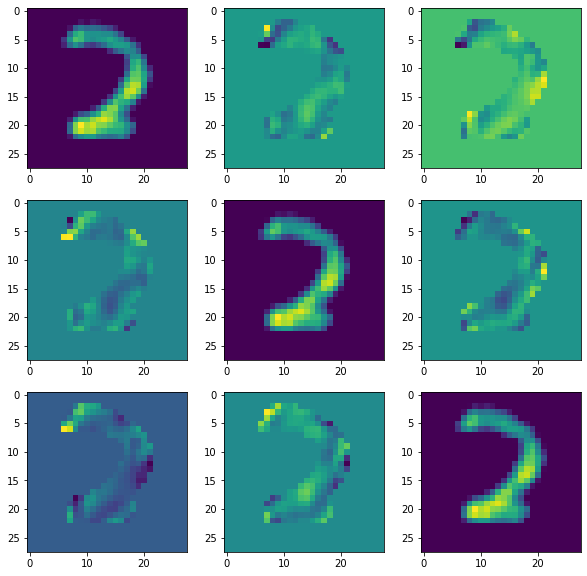

In [10]:
# Show reconstructions
print("Reconstruction")
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3
# This is sampling from the posterior distribution
# This is what it looks like after decoding for different random pulls from the gaussian distribution
for i in range(rows):
    for j in range(columns):
        if i == j:
            img = np.squeeze(outputs_out[i])
        else:
            img = np.squeeze(outputs_out[i]) - np.squeeze(outputs_out[j])
        fig.add_subplot(columns, rows, (i*rows) + j + 1)
        plt.imshow(img)
plt.show()

The learned standard deviation of the logistic output distribution is interesting to visualize. Essentially, it is the learned uncertainty over the dataset per pixel.

Output distribution standard deviation


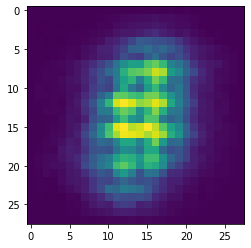

In [11]:
print("Output distribution standard deviation")
plt.imshow(np.squeeze(np.exp(output_log_scale)))

Write code that samples from the VAE by sampling from the prior distribution, decoding with the above learned decoder, and visualizing the output.

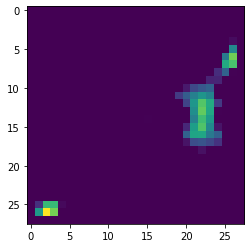

In [12]:
img_shape = [28, 28, 1]

with tf.variable_scope("model", reuse=True) as scope:
    # Run for trivial input of all zeros for both
    m = np.zeros([1,7,7,10], dtype=np.float32)
    l = np.zeros(([1,7,7,10]) , dtype=np.float32)
    
    # Send into code layer to create gaussian distribution
    codes_new = gaussian_sample(m, l)
    # Now send through decoder
    output_new = decoder(codes_new, img_shape)
    # Run through model
    outputs_out = session.run( [output_new], {means: m, log_scales: l})

plt.imshow(np.squeeze(outputs_out[0]))


### t-SNE visualization

(from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html))

t-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

t-SNE will be initialized with the embedding that is generated by PCA in this example, which is not the default setting. It ensures global stability of the embedding, i.e., the embedding does not depend on random initialization.

In [13]:
from time import time

import sklearn.manifold

#flat_train_data = np.reshape(train_data, [-1, 784])
print("Computing t-SNE embedding")
tsne = sklearn.manifold.TSNE(n_components=2, init='pca')
t0 = time()
X_tsne = tsne.fit_transform(flat_train_data)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

Computing t-SNE embedding


NameError: name 'flat_train_data' is not defined